In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('video_games_reviews_train.csv')

In [ ]:
df.head(3)

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,9604,222941,A1U1AK7HKB2BLN,B00CX6XKK6,jayfer,"[4, 51]",ive got to play this on both consoles now and ...,1,wasted 500 dollars on the xbox one.,1385078400,"11 22, 2013"
1,5428,106670,A1L1D50VH2AX7J,B0017UFWMS,Anjoyla,"[0, 0]",This game gives you a series of word puzzles t...,2,Margots Word Brain,1321833600,"11 21, 2011"
2,198,24455,A2JWU211CM0BYE,B00005RCR0,DCN2049,"[0, 1]",You should pretty much already know what this ...,4,"Excellent product, watch the discs",1360540800,"02 11, 2013"


In [ ]:
validation = pd.read_csv('video_games_reviews_dev.csv')
test = pd.read_csv('video_games_reviews_test.csv')

In [ ]:
df.describe()

,level_0,index,overall,unixReviewTime
count,8000.000000,8000.000000,8000.000000,8.000000e+03
mean,6260.770625,115589.872875,3.015625,1.272152e+09
std,3615.950508,66233.495460,1.416909,1.161811e+08
min,0.000000,0.000000,1.000000,9.421920e+08
25%,3123.500000,59116.000000,2.000000,1.206317e+09
50%,6281.500000,113266.500000,3.000000,1.309262e+09
75%,9398.250000,171919.750000,4.000000,1.365228e+09
max,12498.000000,231779.000000,5.000000,1.405987e+09


## Pré-processamento

In [ ]:
#o pré-processamento dos dados de treino, validação e teste foram todos realizados juntos

df['reviewText'] = df['reviewText'].astype(str)
validation['reviewText'] = validation['reviewText'].astype(str)
test['reviewText'] = test['reviewText'].astype(str)
df['stringReview'] = df['reviewText']

Obs: Os dados de treino possuem uma colunas extra chamada 'stringReview' que é nada mais que a review do texto, mas que não será tokenizada. Trabalhei com uma coluna tokenizada e outra não para facilitar principalmente alguns resultados na EDA

In [ ]:
#removendo html tags e transformando o texto em minúsculo
from bs4 import BeautifulSoup
def clean_html(review):
    review = review.lower()
    soup = BeautifulSoup(review, 'html.parser')
    cleaned_text = soup.get_text(separator=" ")
    return cleaned_text

In [ ]:
df['reviewText'] = df['reviewText'].apply(clean_html)
df['stringReview'] = df['stringReview'].apply(clean_html)

validation['reviewText'] = validation['reviewText'].apply(clean_html)
test['reviewText'] = test['reviewText'].apply(clean_html)

In [ ]:
#removendo acentos e pontuação
import unidecode
import string
def remove_accent(review):
    translator = str.maketrans('', '', string.punctuation)
    review = review.translate(translator)
    review = unidecode.unidecode(review)
    return review

In [ ]:
df['reviewText'] = df['reviewText'].apply(remove_accent)
df['stringReview'] = df['stringReview'].apply(remove_accent)

validation['reviewText'] = validation['reviewText'].apply(remove_accent)
test['reviewText'] = test['reviewText'].apply(remove_accent)

Podemos comparar as palavras mais comums que não estão na lista de stopWords do nltk e ver se existem palavras que podem ser adicionadas:

In [ ]:
import nltk
from nltk.corpus import stopwords

stopWords = nltk.corpus.stopwords.words('english')

from collections import Counter
most_commom = Counter(" ".join(df["reviewText"]).split()).most_common(100)
most_commom = dict(most_commom)
most_commom = list(most_commom.keys())
top100 = most_commom[:100]


for word in top100:
    if word not in stopWords:
        print(word)

game
like
games
one
get
play
really
time
good
even
fun
dont
would
much
great
first
also
new
well
graphics
story
way
playing
still
make
better
2
many
im
played
go


Vemos que palavras como "im", "get", "dont" não estão na lista de stopWords mas estão no top100 palavras mais comuns do corpus. Podemos adicioná-las ao conjunto de stopWords uma vez que estas não trazem mudanças significativas na interpretação do texto.
<br> Além disso, "one" também aparece muito. Isso talvez possa ser explicado pelo fato de que o dataset é sobre video games, com informações coletadas até 2014. O Xbox *one* foi lançado justamente em 2013. Porém, vamos deixá-la no corpus

In [ ]:
#acrescentando palavras no conjunto de stopWords

to_add = ['im', 'get', 'dont', 'ive', 'got']
stopWords.extend(to_add)

In [ ]:
#tokenizando retirando stopWords
from nltk.tokenize import word_tokenize
def remove_stopWords(review):
    review = word_tokenize(review)
    
    to_return = []
    for word in review:
        if word not in stopWords:
            to_return.append(word)
    return to_return

In [ ]:
#apenas retirando stopWords, sem tokenizar
from nltk.tokenize import word_tokenize

def rmvStpWrds_string(review):
    review = word_tokenize(review)
    
    to_return = []
    for word in review:
        if word not in stopWords:
            to_return.append(word)
    return " ".join(to_return)

In [ ]:
df['stringReview'] = df['stringReview'].apply(rmvStpWrds_string)
validation['reviewText'] = validation['reviewText'].apply(rmvStpWrds_string)
test['reviewText'] = test['reviewText'].apply(rmvStpWrds_string)

In [ ]:
df['reviewText'] = df['reviewText'].apply(remove_stopWords)

In [ ]:
#lematização

from nltk.stem import WordNetLemmatizer

def lemmatization(review):
    lemmatizer = WordNetLemmatizer()
    
    to_return = []
    for word in review:
        to_return.append(lemmatizer.lemmatize(word))
    return(to_return)

In [ ]:
def lemmatizationString(review):
    lemmatizer = WordNetLemmatizer()
    
    review = word_tokenize(review)
    to_return = []
    for word in review:
        to_return.append(lemmatizer.lemmatize(word))
    return " ".join(to_return)

In [ ]:
df['reviewText'] = df['reviewText'].apply(lemmatization)

In [ ]:
df['stringReview'] = df['stringReview'].apply(lemmatizationString)
validation['reviewText'] = validation['reviewText'].apply(lemmatizationString)
test['reviewText'] = test['reviewText'].apply(lemmatizationString)

### EDA 

Text(0, 0.5, 'Quantidade')

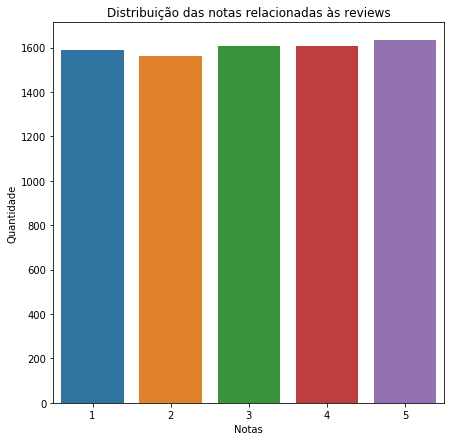

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
x=df['overall']
fig = sns.countplot(x)
fig.set_title('Distribuição das notas relacionadas às reviews')
fig.set_xlabel('Notas')
fig.set_ylabel('Quantidade')

In [ ]:
df['reviewLength'] = df['reviewText'].apply(lambda x: len(x))

In [ ]:
import numpy as np
grouped = df.groupby(by='overall').mean()
mean_lengths = list(grouped['reviewLength'])

X = np.ones((len(mean_lengths), 2))
X[:,0] = mean_lengths
X[:,1] = np.array([1,2,3,4,5])

plot = pd.DataFrame(X, columns=['Mean', 'Overall'])
plot['Overall'].astype(int)
plot

,Mean,Overall
0,95.839723,1.0
1,117.923225,2.0
2,129.551617,3.0
3,125.638854,4.0
4,90.729167,5.0


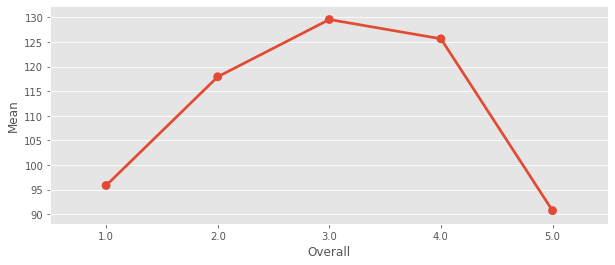

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(10,4))
sns.pointplot(x='Overall', y='Mean', data=plot)

### Tamanho das reviews 

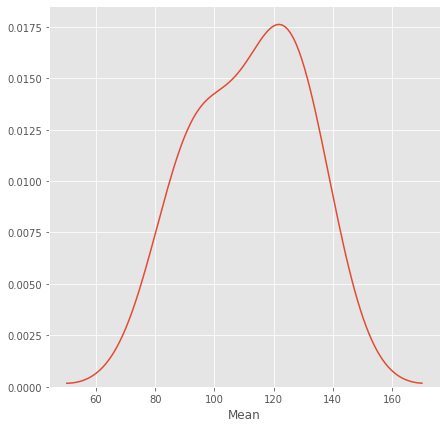

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(7,7))
sns.distplot(plot['Mean'], hist=False)

Vemos que a distribuição de palavras para cada categoria de Overall é quase normal, ou seja, reviews muito positivas ou negativas tendem a ter uma menor quantidade de palavras, enquanto reviews médias, tendem a ter a maior quantidade de palavras. Esse fato pode ser interessante depois

### Classes gramaticais 

In [ ]:
import nltk
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/murilo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
#dentre todas as categorias providenciadas pelo nltk, optei pelas mais comuns, que estão descritas abaixo:

foreignWord = 'FW'
adjective = ['JJ','JJR', 'JJS']
noun = ['NN', 'NNP', 'NNPS', 'NNS']
adverb = ['RB', 'RBR', 'RBS']
verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def foreignWord_count(review):
    tagged = pos_tag(review)
    tags = dict(tagged)
    tags = list(tags.values())
    
    counter = 0
    for tag in tags:
        if tag in foreignWord:
            counter = counter + 1
    return counter


def adjective_count(review):
    tagged = pos_tag(review)
    tags = dict(tagged)
    tags = list(tags.values())
    
    counter = 0
    for tag in tags:
        if tag in adjective:
            counter = counter + 1
    return counter


def noun_count(review):
    tagged = pos_tag(review)
    tags = dict(tagged)
    tags = list(tags.values())
    
    counter = 0
    for tag in tags:
        if tag in noun:
            counter = counter + 1
    return counter


def adverb_count(review):
    tagged = pos_tag(review)
    tags = dict(tagged)
    tags = list(tags.values())
    
    counter = 0
    for tag in tags:
        if tag in adverb:
            counter = counter + 1
    return counter


def verb_count(review):
    tagged = pos_tag(review)
    tags = dict(tagged)
    tags = list(tags.values())
    
    counter = 0
    for tag in tags:
        if tag in verbs:
            counter = counter + 1
    return counter

In [ ]:
df['foreignWords'] = df['reviewText'].apply(foreignWord_count)
df['adjectives'] = df['reviewText'].apply(adjective_count)
df['nouns'] = df['reviewText'].apply(noun_count)
df['adverbs'] = df['reviewText'].apply(adverb_count)
df['verbs'] = df['reviewText'].apply(verb_count)

In [ ]:
tagsGrouped = df.groupby(by='overall').mean()

In [ ]:
tagsGrouped

,level_0,index,unixReviewTime,reviewLength,foreignWords,adjectives,nouns,adverbs,verbs
overall,,,,,,,,,
1,6185.993715,120203.130735,1.277902e+09,95.839723,0.101823,15.054054,29.971716,6.752357,15.103708
2,6246.039667,112137.213052,1.264509e+09,117.923225,0.094690,18.961612,35.246961,8.731926,17.664747
3,6239.220771,114461.208955,1.270911e+09,129.551617,0.129353,20.802861,38.475746,9.283582,18.833333
4,6260.315068,113845.773973,1.264280e+09,125.638854,0.153176,20.393524,37.939601,8.948319,17.846824
5,6369.458333,117227.574142,1.282836e+09,90.729167,0.108456,14.995098,28.308824,6.265319,12.930760


In [ ]:
meanVerbs = tagsGrouped['verbs']
meanforeignWords = tagsGrouped['foreignWords']
meanAdjectvies = tagsGrouped['adjectives']
meanNouns = tagsGrouped['nouns']
meanAdverbs = tagsGrouped['adverbs']
meanLength = tagsGrouped['reviewLength']

Y = np.ones((5, 7))
Y[:,0] = meanVerbs
Y[:,1] = meanforeignWords
Y[:,2] = meanAdjectvies
Y[:,3] = meanNouns
Y[:,4] = meanAdverbs    
Y[:,5] = meanLength
Y[:,6] = np.array([1,2,3,4,5])

plot2 = pd.DataFrame(Y, columns=['verbs', 'foreignWords', 'adjectives', 
                                 'nouns','adverbs','length', 'Overall'])
plot2['Overall'].astype(int)
plot2

,verbs,foreignWords,adjectives,nouns,adverbs,length,Overall
0,15.103708,0.101823,15.054054,29.971716,6.752357,95.839723,1.0
1,17.664747,0.094690,18.961612,35.246961,8.731926,117.923225,2.0
2,18.833333,0.129353,20.802861,38.475746,9.283582,129.551617,3.0
3,17.846824,0.153176,20.393524,37.939601,8.948319,125.638854,4.0
4,12.930760,0.108456,14.995098,28.308824,6.265319,90.729167,5.0


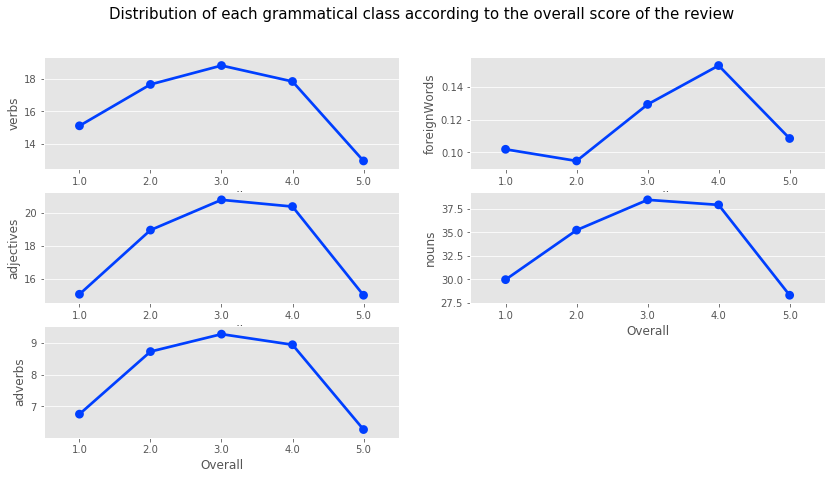

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 7))
plt.style.use("seaborn-bright")

sns.pointplot(x='Overall', y='verbs', data=plot2, ax=axes[0,0])
sns.pointplot(x='Overall', y='foreignWords', data=plot2, ax=axes[0,1])
sns.pointplot(x='Overall', y='adjectives', data=plot2, ax=axes[1,0])
sns.pointplot(x='Overall', y='nouns', data=plot2, ax=axes[1,1])
sns.pointplot(x='Overall', y='adverbs', data=plot2, ax=axes[2,0])
plt.suptitle('Distribution of each grammatical class according to the overall score of the review', fontsize=15)

fig.delaxes(axes[2,1])

### Palavras mais frequentes por tipo de review (positiva - negativa) 

In [ ]:
def get_score(overall):
    if overall > 3:
        return 1  #positivo
    else:
        return 0  #negativo

In [ ]:
df['score'] = df['overall'].apply(get_score)
validation['score'] = validation['overall'].apply(get_score)
test['score'] = test['overall'].apply(get_score)

In [ ]:
from collections import Counter

counterPos = Counter()
counterNeg = Counter()
counterTotal = Counter()

reviewVec = df['reviewText']
overallVec = df['overall']
scoreVec = df['score']

In [ ]:
from tqdm import tqdm_notebook as tqdm

for i in tqdm(range(len(reviewVec))):
    try:
        for word in reviewVec[i]:        
            counterTotal[word] += 1

            if(scoreVec[i]==1):
                counterPos[word] += 1

            if(scoreVec[i]==0):
                counterNeg[word] += 1
    except:   
        continue

/home/murilo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
dictCounterNeg = dict(counterNeg.most_common()[0:20])
dictCounterPos = dict(counterPos.most_common()[0:20])

In [ ]:
dfPos = pd.DataFrame.from_dict(dictCounterPos, orient='index', columns=['amount'])
dfPos.reset_index(inplace=True)
dfPos.rename(columns={'index':'word'}, inplace=True)

dfPos.drop(index=0, axis=0, inplace=True)


dfNeg = pd.DataFrame.from_dict(dictCounterNeg, orient='index', columns=['amount'])
dfNeg.reset_index(inplace=True)
dfNeg.rename(columns={'index':'word'}, inplace=True)

dfNeg.drop(index=0, axis=0, inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

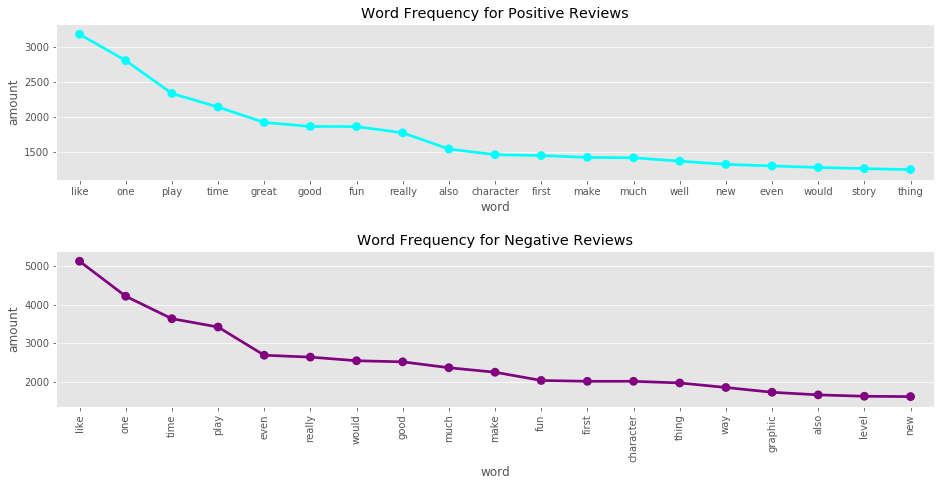

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 7))
plt.style.use("seaborn-bright")
fig.tight_layout(pad=5.0)

axes[0].set_title('Word Frequency for Positive Reviews')
sns.pointplot(x='word', y='amount', data=dfPos, ax=axes[0], color='cyan')
plt.xticks(rotation=90)

axes[1].set_title('Word Frequency for Negative Reviews')
sns.pointplot(x='word', y='amount', data=dfNeg, ax=axes[1], color='purple')
plt.xticks(rotation=90)

## Modelagem e Feature Engineering 

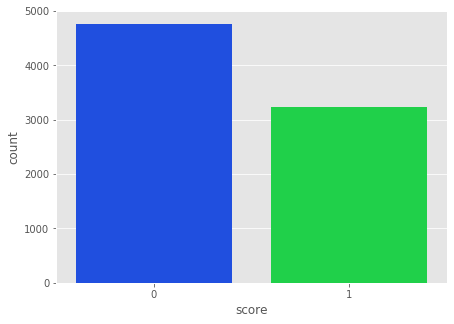

In [ ]:
plt.figure(figsize=(7,5))
sns.countplot(df['score'])

In [ ]:
df['score'].value_counts()

0    4762
1    3238
Name: score, dtype: int64

Essa diferença não é suficiente para que um tratamento de desbalanceamento seja feito

### BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True, max_features=5000)
X_bow = vectorizer.fit_transform(df['stringReview'])

In [ ]:
X_bow_vec = X_bow.toarray()
words = list(vectorizer.get_feature_names())
BoW = pd.DataFrame(X_bow_vec, columns=words)

In [ ]:
BoW

,07,08,09,10,100,1000,1015,1080p,11,12,...,youthe,youtube,youve,yr,zelda,zero,zip,zombie,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Se determinada palavra for muito comum no corpus, ou muito rara, muito provavelmente não vai acrescentar quase nada para a classificação das reviews, por isso vou retirá-las

In [ ]:
BoW = BoW.drop([col for col, val in BoW.sum().iteritems() if val < 50], axis=1)
BoW = BoW.drop([col for col, val in BoW.sum().iteritems() if val > 7000], axis=1)

Além disso podemos tentar diminuir a dimensão dos dados através do PCA.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
X = StandardScaler().fit_transform(BoW.values)

PCA_solver = PCA(svd_solver='full')
X_transformed = PCA_solver.fit(X)

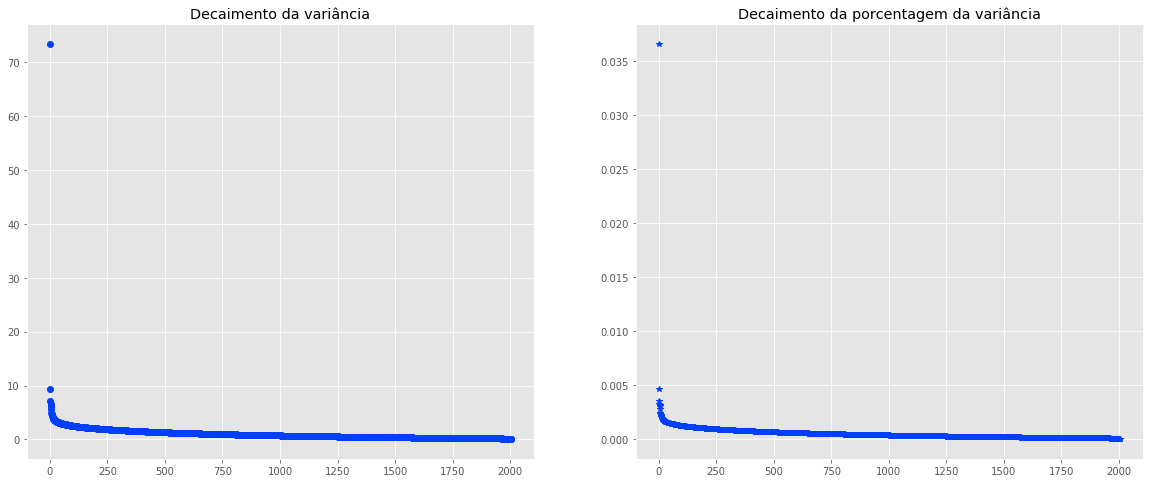

In [ ]:
#decaimento da variância e porcentagem de explicabilidade
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.set(title='Decaimento da variância')
ax1.plot(PCA_solver.explained_variance_, 'o')
ax2.set(title='Decaimento da porcentagem da variância')
ax2.plot(PCA_solver.explained_variance_ratio_, '*')

Podemos ver que uma direção principal tem mais de 35% de explicabilidade dos dados, enquanto a grande maioria tem uma porcentagem muito baixa.

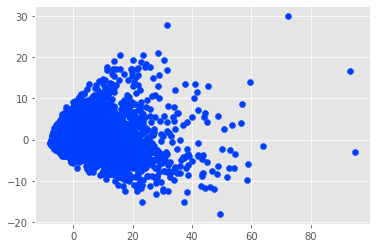

In [ ]:
#projetando em 2D
projection = PCA(n_components=2)
data2d = projection.fit_transform(X)
plt.scatter(data2d[:,0],data2d[:,1])

Podemos perceber alguns outliers, que iremos retirar para melhorar a performance do PCA

In [ ]:
#retirando outliers manualmente
rids = np.argwhere(data2d[:,0]>68)
rids = [i for i in rids.flat]
rindex = BoW.index[rids]

BoW = BoW.drop(rindex, axis=0)
df = df.drop(rindex, axis=0)

In [ ]:
X = BoW.values
X = StandardScaler().fit_transform(X)

PCA_solver2 = PCA(svd_solver='full')
X_transformed = PCA_solver2.fit(X)

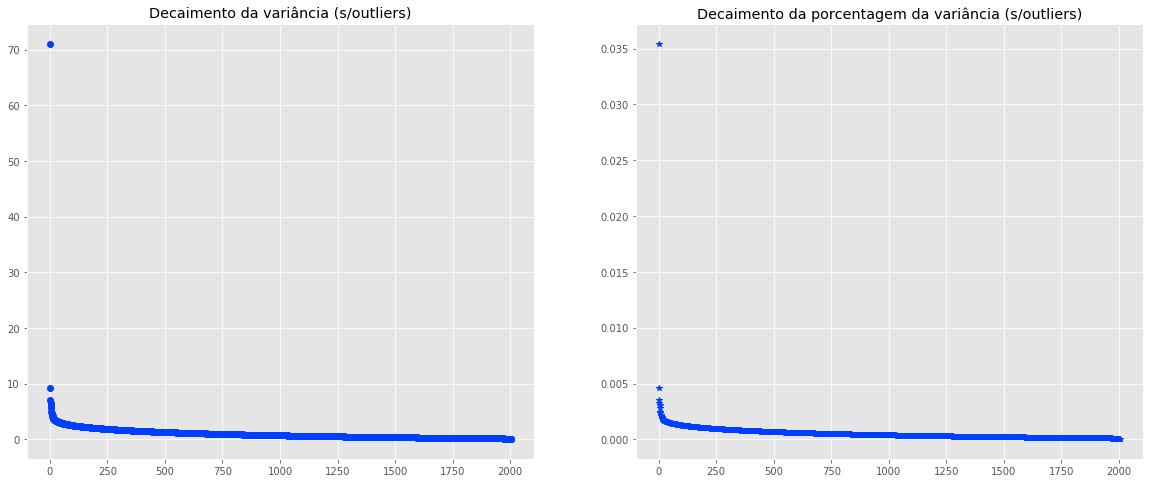

In [ ]:
#decaimento da variância e porcentagem de explicabilidade sem outliers
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.set(title='Decaimento da variância (s/outliers)')
ax1.plot(PCA_solver2.explained_variance_, 'o')
ax2.set(title='Decaimento da porcentagem da variância (s/outliers)')
ax2.plot(PCA_solver2.explained_variance_ratio_, '*')

Finalmente, para reduzir a dimensão dos dados, podemos ver quantas direções são necessárias para termos 90% de explicabilidade dos dados.

In [ ]:
def qtd_dir(treshold, data):
    PCA_solver = PCA(svd_solver='full')
    data_transformed = PCA_solver.fit(data)
    
    percentages = PCA_solver.explained_variance_ratio_
    total = 0
    i = 0
    while total < 0.8:
        total = total + percentages[i]
        i = i + 1
    return i

In [ ]:
#quantidade de direções para 90% de explicabilidade dos dados
qtd_dir(0.9, X)

1001

Precisamos de 1001 componentes para ter 90% da informação dos dados, portanto vamos calcular o PCA com as 1001 direções principais

In [ ]:
#Dados finais
pca = PCA(n_components=1001)
pca.fit(X)
X_reduced = pca.transform(X)

In [ ]:
#realizando o mesmo processamento para o conjunto de validação e de teste

X_bow_val = vectorizer.fit_transform(validation['reviewText'])
X_bow_val_vec = X_bow_val.toarray()
words = list(vectorizer.get_feature_names())
BoW_val = pd.DataFrame(X_bow_val_vec, columns=words)

X_val_normalized = sc.fit_transform(BoW_val.values)

X_val_normalized_reduced = pca.fit_transform(X_val_normalized)



X_bow_test = vectorizer.fit_transform(test['reviewText'])
X_bow_test_vec = X_bow_test.toarray()
words = list(vectorizer.get_feature_names())
BoW_test = pd.DataFrame(X_bow_test_vec, columns=words)

X_test_normalized = sc.fit_transform(BoW_test.values)

X_test_normalized_reduced = pca.fit_transform(X_test_normalized)


Agora com os dados finalmente pré-processados podemos treinar alguns modelos.

### Treino e tuning dos parâmetros com os dados de validação

### RandomForest

In [ ]:
y_train = df['score']

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.metrics import accuracy_score, confusion_matrix

clf = rf(n_estimators = 500)
clf = clf.fit(X_reduced, y_train)

y_val_predicted = clf.predict(X_val_normalized_reduced)
print('Accuracy:', accuracy_score(validation['score'], y_val_predicted))

Accuracy: 0.5935


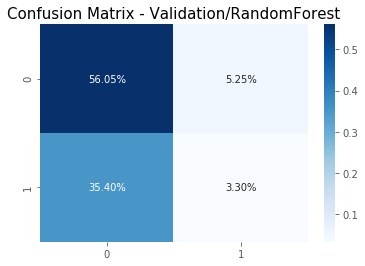

In [ ]:
plt.figure()
plt.title('Confusion Matrix - Validation/RandomForest', fontsize=(15))
cf_matrix = confusion_matrix(validation['score'], y_val_predicted)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

### SVM

In [ ]:
from sklearn import svm

svm_clf = svm.SVC(kernel='poly')
svm_clf.fit(X_reduced, y_train)

svmPredict = svm_clf.predict(X_val_normalized_reduced)
print('Accuracy:', accuracy_score(validation['score'], svmPredict))

Accuracy: 0.5965


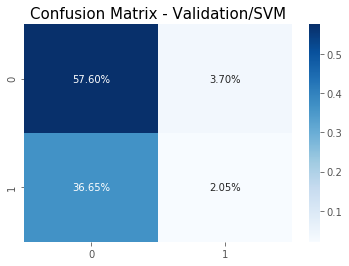

In [ ]:
plt.figure()
plt.title('Confusion Matrix - Validation/SVM', fontsize=(15))
cf_matrix = confusion_matrix(validation['score'], svmPredict)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

### Predição dos dados de teste

In [ ]:
test_clf_prediction = clf.predict(X_test_normalized_reduced)
print('Accuracy:', accuracy_score(test['score'], test_clf_prediction))

Accuracy: 0.5864


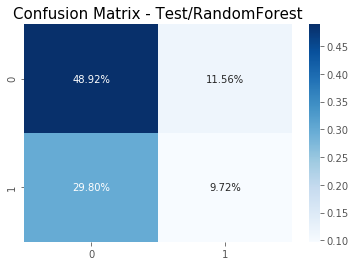

In [ ]:
plt.figure()
plt.title('Confusion Matrix - Test/RandomForest', fontsize=(15))
cf_matrix = confusion_matrix(test['score'], test_clf_prediction)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
test_svm_prediction = svm_clf.predict(X_test_normalized_reduced)
print('Accuracy:', accuracy_score(test['score'], test_svm_prediction))

Accuracy: 0.5936


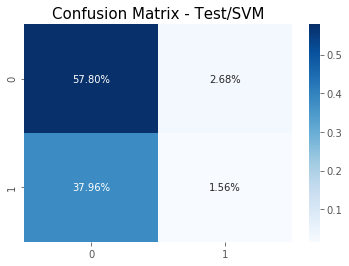

In [ ]:
plt.figure()
plt.title('Confusion Matrix - Test/SVM', fontsize=(15))
cf_matrix = confusion_matrix(test['score'], test_svm_prediction)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

### Conclusão

A acurácia foi escolhida como uma das medidas pelo fato de ser mais direta e possuir interpretação mais simples. Já a matriz de confusão é uma maneira de ter um melhor detalhamento da performance do algoritmo.

<br> Considerando que comentários positivos são mais importantes pelo fato de que mostram quais são os produtos que os clientes mais gostam, a matriz de confusão é uma boa opção, e portanto o modelo SVM poderia ser escolhido, uma vez que possui mais TP do que o modelo Random Forest.